# Processing Sequences Using RNNs and CNNs

No GPU was detected.


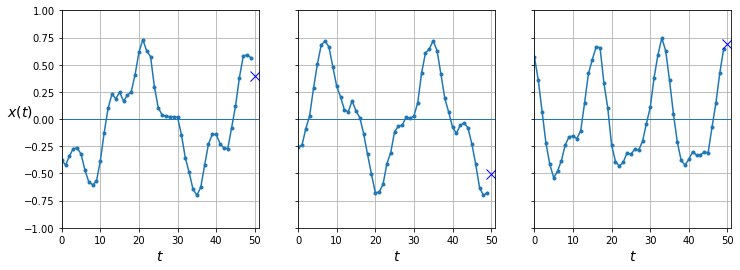

In [1]:
# FIXME: meke autocompletion working again
%config Completer.use_jedi = False

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')

if not physical_devices:
    print("No GPU was detected.")
else:
    # https://stackoverflow.com/a/60699372
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
from tensorflow import keras

# Set RNG state
np.random.seed(42)
tf.random.set_seed(42)


def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    # wave 1
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    # add wave 2
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    # add noise
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)


# Generate a dataset of fixed length sequences
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

# Split the dataset into training, validation and test parts
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]


def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    
    if x_label:
        plt.xlabel(x_label, fontsize=14)
    
    if y_label:
        plt.ylabel(y_label, fontsize=14, rotation=0)
    
    plt.grid(True)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])


# Plot few series from the validation set
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=("$x(t)$" if col == 0 else None))
    
plt.show()

## Baseline predictors

### Naive predictor
The simplest baseline benchmark is a predictor that predicts the last observed value.

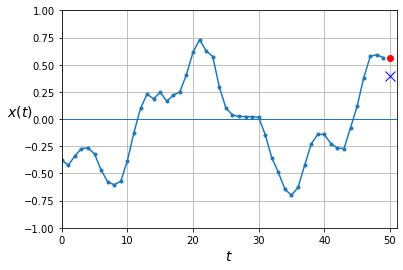

In [2]:
# Naive prediction
y_pred = X_valid[:, -1]

# Plot the prediction and actual value
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [3]:
# Validation accuracy of the Naive predictor
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

### Linear predictor
Another benchmark is a simple linear regressor trained for couple of epochs.

In [4]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build simple univariate linear model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")

# Train and validate the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Show the validation set accuracy
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0062

0.004168087150901556

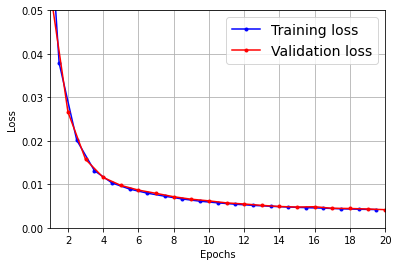

In [6]:
import matplotlib as mpl

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# Plot learning curves for the linear regressor
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

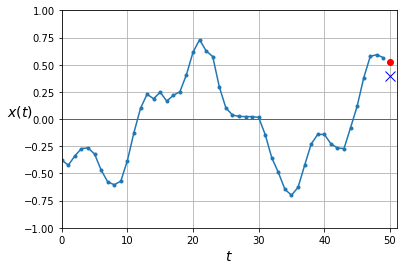

In [7]:
# Make a prediction of the validation set
y_pred = model.predict(X_valid)

# Plot one series from the validation set
#  - and compare target and predicted values
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Implementing a Simple RNN

In [8]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build simple RNN with single neuron
#  - input shape is `None` because recurrent neurons (layers) accept arbitrary number of (repeated) inputs
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

# Train and validate the model
#  - RNNs are trained using *Backpropagation Through Time (BPTT)*
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Show validation set accuracy
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 3s 8ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0117 - val_loss: 0.0110

0.010881561785936356

Notice that with single neuron RNN we've not yet beaten the linear regressor. However, compared to the linear model, this RNN uses only 3 parameters! Those are the weights of the input at particular time, the hidden state (which in this case is simply neuron's feedback from previous timestamp) and the bias term.

So the first advantage of this approach is model's compactness. Moreover, our RNN was extremely simple and there's a good chance we can do better without blowing the model up too much.

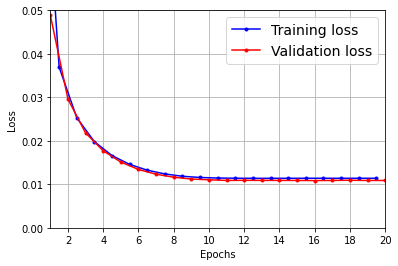

In [9]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

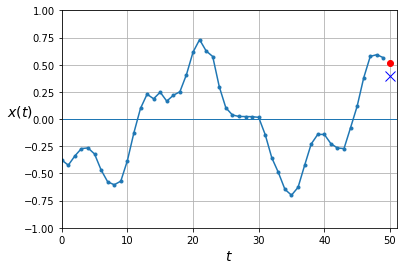

In [10]:
y_pred = model.predict(X_valid)

plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [11]:
# Reset RNG state
np.random.seed(42)
tf.random.set_seed(42)

# Build multi-layer RNN
#  - by default RNN layers return just their last output, `return_sequences` must be enabled to pass all outputs to upper recurrent layers
#  - in this task we care only about the last output (predicted value one step ahead), so the last layer doesn't have to return full sequence
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model.compile(loss="mse", optimizer="adam")

# Train and validate the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Evaluate the model on the validation set
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 10s 38ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0035 - val_l

0.0029105644207447767

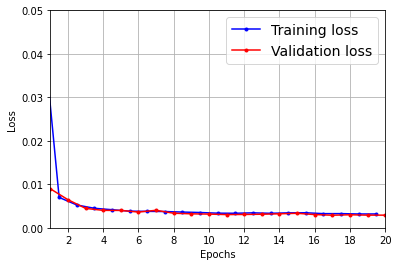

In [12]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

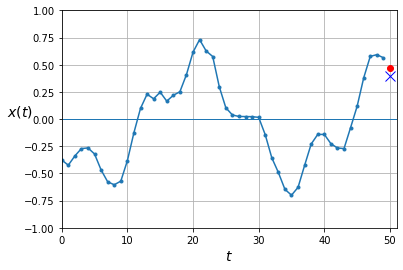

In [13]:
y_pred = model.predict(X_valid)

plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Because our task only asks for the very last value (the prediction one step ahead the input series), we could replace the last recurrent layer by a simple single neuron dense layer. This can be justified because all the information that must be carried over time frames is probably captured in the first two layers and we force the single neuron output layer just because of the univariate task. Moreover, we can use any activation function we want in the dense layer, whereas `SimpleRNN` neurns use *tanh*.

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

# Build a model with two recurrent layers and dense univariate output
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")

# Train and validate the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Evaluate the model on the validation set
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 5s 19ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0029 - val_lo

0.002623624401167035

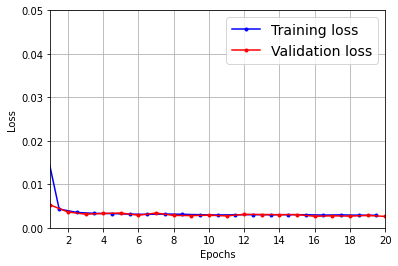

In [15]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

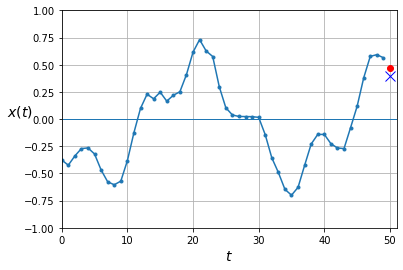

In [16]:
y_pred = model.predict(X_valid)

plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()